In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import xgboost as xgb
from sklearn.svm import SVC
import os

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, RocCurveDisplay, roc_curve
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
import seaborn as sns
import joblib
import sklearn.utils
from matplotlib import pyplot as plt




In [7]:
folder = '/Users/darrenhum/pCloud Drive/Data Science/Learning - MAGES/University Application Acceptance/Data/'
X_test = pd.read_csv(os.path.join(folder, 'X_test.csv'))
X_train = pd.read_csv(os.path.join(folder, 'X_train.csv'))
y_train = pd.read_csv(os.path.join(folder, 'y_train.csv'))
y_test = pd.read_csv(os.path.join(folder, 'y_test.csv'))

In [8]:
X_train.shape

(76652, 35)

In [9]:
# function to run the model after fit and save relavent information into the dictionary
all_results = {}
def result_report(model, modelname, iteration, X_train = X_train, X_test = X_test):
    
    #running all the models
    train_result = model.predict(X_train)
    test_result = model.predict(X_test)
    test_result_prob = model.predict_proba(X_test)
    train_result_prob = model.predict_proba(X_train)

    #generating overall metrics
    report_train = classification_report(y_train, train_result, output_dict=True)
    report_test = classification_report(y_test, test_result, output_dict=True)

    #generating auc
    auc = metrics.roc_auc_score(y_test, test_result_prob[:,1])
    auc_train = metrics.roc_auc_score(y_train, train_result_prob[:,1])

    #saving the metrics
    dict_var = {}
    dict_var['train'] = report_train
    dict_var['test'] = report_test
    dict_var['test']['auc'] = auc
    dict_var['train']['cm'] = confusion_matrix(y_train, train_result)
    dict_var['test']['cm'] = confusion_matrix(y_test, test_result)

    all_results[f'{modelname}-{iteration}'] = dict_var

    #print auc
    return print('train:', auc_train, 'test:', auc)

In [74]:
def cm_heatmap(array):
    perc = (array.T/np.sum(array)).T
    cm = sns.heatmap(perc, annot=True, fmt='.1%')
    return cm

We will run several models and select the best.

### Model - XGBOOST

#### 1st Iteration

In [10]:
# First Iteration
xg = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric='auc', 
                            random_state = 24)
xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, reg_lambda=1, ...)

In [11]:
result_report(xg, 'xgb', 1)


train: 0.9765661131852339 test: 0.8992662304474297


We see the model here is overfitting to the training data. We need to reduce complexity. Let's try:
- reducing the max_depth parameter from the default of 6
- increasing the gamma from the default of 0
- subsampling

#### 2nd Iteration

In [12]:
xg2 = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric='auc', 
                            random_state = 24,
                            
                            max_depth = 3,
                            gamma = 0.5,
                            subsample = 0.35,
                            scale_pos_weight = 2)
xg2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, reg_lambda=1, ...)

In [13]:
result_report(xg2, 'xgb', 2)

train: 0.9518038094973922 test: 0.8992173383174942


In [15]:
# ROUND 1: First set of parameters ------------------
param_grid_xg = {
    'max_depth': [4, 5],
    'eta': [0.1, 0.2],
    'min_child_weight' : [1, 2],
    'lambda' : [1,2],
    'gamma': [0.2, 0.5],
    'scale_pos_weight': [1, 1.5],
    
    'subsample' : [0.8],
    'colsample_bytree' : [0.8]
    
}

grid_model_xg = GridSearchCV(param_grid= param_grid_xg, 
                             estimator= xg2,
                             scoring='roc_auc',
                             cv= 4, 
                             verbose=1)

grid_model_xg.fit(X_train, y_train)

grid_model_xg.best_params_

Fitting 4 folds for each of 64 candidates, totalling 256 fits


{'colsample_bytree': 0.8,
 'eta': 0.1,
 'gamma': 0.2,
 'lambda': 1,
 'max_depth': 5,
 'min_child_weight': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8}

{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'scale_pos_weight': 1}
{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 4}
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'scale_pos_weight': 1}


In [16]:
xg3 = xgb.XGBClassifier(    objective='binary:logistic', 
                            eval_metric='auc', 
                            random_state = 24,
                            
                            colsample_bytree = 0.8,
                            eta = 0.1,
                            gamma = 0.2,
                            reg_lambda = 1,
                            max_depth = 5,
                            min_child_weight = 1,
                            scale_pos_weight = 1,
                            subsample = 0.8
                        )
xg3.fit(X_train, y_train)



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric='auc', gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, ...)

In [17]:
result_report(xg3, 'xgb', 3)

train: 0.9545609405937171 test: 0.8805640082171949


### SVM

In [18]:
svc = SVC()
svc.fit(X_train, y_train.values.ravel())

SVC()

In [19]:
result_svm_train = svc.predict(X_train)
result_svm_test =  svc.predict(X_test)


In [82]:
print(classification_report(y_train, result_svm_train))
print(classification_report(y_test, result_svm_test))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83     38326
           1       0.87      0.73      0.80     38326

    accuracy                           0.81     76652
   macro avg       0.82      0.81      0.81     76652
weighted avg       0.82      0.81      0.81     76652

              precision    recall  f1-score   support

           0       0.90      0.86      0.88     12775
           1       0.63      0.72      0.67      4342

    accuracy                           0.82     17117
   macro avg       0.76      0.79      0.77     17117
weighted avg       0.83      0.82      0.83     17117



### Random Forest

In [44]:
rf = RandomForestClassifier(random_state = 77)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=77)

In [45]:
result_report(rf, 'rf', 1)

train: 0.9999981999918964 test: 0.8726052906981462


Due to overfit, let's consider modifying the following parameters:
- min_samples_split : default 2 
    - With default 2, trees continuing splitting even with 2 observations, resulting in bigger trees that might overfit
- max_depth : default None
    - Related to above, trees are allowed to grow until leaves are pure
- max_leaf_nodes : default None
    - leave as it is?
- min_samples_leaf : default 
    - similar to min_samples_split as it controls generating new splits
- max_features : default = auto
- max_samples : default = None


#### 2nd Iteration

In [46]:
rf2 = RandomForestClassifier(   random_state = 77,
                                n_estimators = 75,
                                min_samples_split = 20,
                                max_samples = 0.5
                                )
rf2.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_samples=0.5, min_samples_split=20, n_estimators=75,
                       random_state=77)

In [47]:
result_report(rf2, 'rf', 2)

train: 0.9836888473695491 test: 0.8801921341721193


In [48]:
param_dict_rf = {   #'random_state'      : 77,
                    'n_estimators'      : [25, 50, 75, 100],
                    'max_depth'         : [5, 6, 7, 8],
                    'min_samples_split' : [10, 20, 30],
                    'max_samples'       : [0.2, 0.5, 0.75]
                }

In [49]:
grid_model_rf = GridSearchCV(   param_grid = param_dict_rf,
                                estimator = rf2,
                                cv = 5,
                                verbose = 1
                            )

In [50]:
grid_model_rf.fit(X_train, y_train.values.ravel())
grid_model_rf.best_params_


Fitting 5 folds for each of 144 candidates, totalling 720 fits


{'max_depth': 8,
 'max_samples': 0.5,
 'min_samples_split': 30,
 'n_estimators': 50}

#### 3rd Iteration

In [51]:
rf3 = RandomForestClassifier(   random_state = 77,
                                n_estimators = 50,
                                max_depth = 8,
                                min_samples_split = 30,
                                max_samples = 0.5
                                )
rf3.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=8, max_samples=0.5, min_samples_split=30,
                       n_estimators=50, random_state=77)

In [52]:
result_report(rf3, 'rf', 3)

train: 0.9121645120183886 test: 0.8891495076984373


In [53]:
df_feature_rf = pd.DataFrame( {'feature' : X_train.columns, 'importance' : rf3.feature_importances_ })

In [54]:
#ranking features by importance to the model
df_feature_rf.sort_values(by='importance')

,feature,importance
16,institution_GB005,0.000066
12,institution_AU004,0.000145
20,adm_appl_method_HRD,0.000262
18,institution_GB008,0.000329
14,institution_GB002,0.000382
17,institution_GB007,0.000420
21,adm_appl_method_PPG,0.000619
32,race_code_MALAY,0.000774
23,adm_appl_method_WWW,0.000998
28,appl_first_citizenship_P,0.001313


#### 4th Iteration

Let's try dropping features the lowest 10 features.

In [55]:
feature_list_to_drop = df_feature_rf.sort_values(by='importance')['feature'][0:10].tolist()

In [56]:

X_train_1 = X_train.drop(feature_list_to_drop, axis=1)
X_test_1 = X_test.drop(feature_list_to_drop, axis=1)


In [57]:
rf4 = RandomForestClassifier(   random_state = 77,
                                n_estimators = 75,
                                min_samples_split = 20,
                                max_samples = 0.5,
                                max_depth = 8
                                )
rf4.fit(X_train_1, y_train.values.ravel())


RandomForestClassifier(max_depth=8, max_samples=0.5, min_samples_split=20,
                       n_estimators=75, random_state=77)

In [58]:
result_report(rf4, 'rf', 4, X_train=X_train_1, X_test=X_test_1)

train: 0.9218447581703955 test: 0.9024255327971185


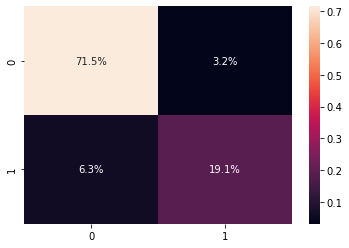

In [60]:
cm_heatmap(all_results['rf-4']['test']['cm'])

### Log Reg

In [61]:
lr = LogisticRegression(random_state = 24)

lr.fit(X_train, y_train.values.ravel())

LogisticRegression(random_state=24)

In [62]:
result_report(lr, 'lr', 1)

train: 0.6869005447105007 test: 0.6835263538856352


### Naive Bayes

In [66]:
nb = GaussianNB()
nb.fit(X_train, y_train.values.ravel())

GaussianNB()

In [67]:
result_report(nb, 'nb', 1)

train: 0.7033151174737164 test: 0.6835266874049583


### Compare Results

In [68]:
model = []
precision = []
recall = []
auc = []
accuracy = []
for k in all_results.keys():
    model.append(k)
    precision.append(all_results[k]['test']['1']['precision'])
    recall.append(all_results[k]['test']['1']['recall'])
    auc.append(all_results[k]['test']['auc'])
    accuracy.append(all_results[k]['test']['accuracy'])

In [69]:
d = {   'model': model,
        'precision': precision,
        'recall' : recall,
        'accuracy' : accuracy,
        'auc' : auc
        }
df_result = pd.DataFrame(d)
df_result.sort_values(by='model')

,model,precision,recall,accuracy,auc
7,lr-1,0.397935,0.621373,0.665479,0.683526
8,lr-2,0.397935,0.621373,0.665479,0.683527
9,nb-1,0.273540,0.909258,0.364433,0.683527
3,rf-1,0.777279,0.757946,0.883508,0.872605
4,rf-2,0.805128,0.759327,0.892329,0.880192
5,rf-3,0.573043,0.817596,0.799205,0.889150
6,rf-4,0.857556,0.751497,0.905299,0.902426
0,xgb-1,0.316057,0.957854,0.463516,0.899266
1,xgb-2,0.419154,0.899125,0.658351,0.899217
2,xgb-3,0.607990,0.785122,0.817082,0.880564


In [ ]:
all_results['rf-4']['test']['1']

{'precision': 0.8575558475689882,
 'recall': 0.7514970059880239,
 'f1-score': 0.8010310543758439,
 'support': 4342}

Text(33.0, 0.5, 'True Values')

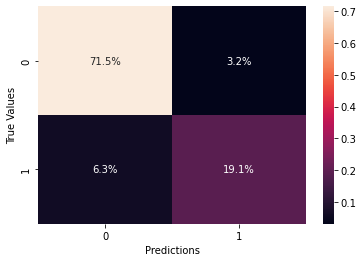

In [75]:
rf_cm = cm_heatmap(all_results['rf-4']['test']['cm'])
rf_cm.set_xlabel("Predictions")
rf_cm.set_ylabel("True Values")

Text(33.0, 0.5, 'True Values')

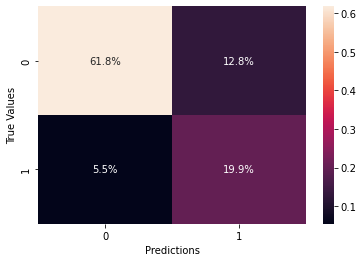

In [77]:
xgb_cm = cm_heatmap(all_results['xgb-3']['test']['cm'])
xgb_cm.set_xlabel("Predictions")
xgb_cm.set_ylabel("True Values")

In [80]:
all_results['xgb-3']['test']['1']

{'precision': 0.6079900124843945,
 'recall': 0.7851220635651773,
 'f1-score': 0.6852950045230677,
 'support': 4342}

In [86]:
#rf4 seems like the best model so we will save that model
joblib.dump(rf4, 'model_rf')

['model_rf']